## Visualizing heatmaps of class activation

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import pathlib
from PIL import Image, ImageOps

In [15]:
class_names = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
layers_to_compare = ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
TARGET_LAYER_NAME = "block4_conv3"

In [16]:
try:
    model
except NameError:
    print("Ladataan malli...")
    model = keras.models.load_model("expressdetect_double96.keras")

In [17]:
def get_gradcam_model(target_layer_name):
    vgg_layer = model.get_layer("vgg16")
    internal_conv_layer = vgg_layer.get_layer(target_layer_name)

    vgg_sub_model = keras.models.Model(
        inputs=vgg_layer.inputs,
        outputs=[internal_conv_layer.output, vgg_layer.output]
    )

    classifier_layers = []
    found_vgg = False
    for layer in model.layers:
        if layer.name == 'vgg16':
            found_vgg = True
            continue
        if found_vgg:
            classifier_layers.append(layer)

    return vgg_sub_model, classifier_layers

vgg_sub_model, classifier_layers = get_gradcam_model(TARGET_LAYER_NAME)


In [18]:
def make_gradcam_heatmap(img_array, class_index=None):
    img_tensor = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        # A) Esikäsittely
        x = keras.applications.vgg16.preprocess_input(tf.identity(img_tensor))
        x = x * (1.0 / 255.0)

        # B) VGG-vaihe
        conv_outputs, vgg_output = vgg_sub_model(x, training=False)

        # C) Luokittelija-vaihe
        x_out = vgg_output
        for layer in classifier_layers:
            x_out = layer(x_out, training=False)

        predictions = x_out

        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)

    # Normalisointi
    max_val = tf.math.reduce_max(heatmap)
    if max_val == 0:
        max_val = 1e-10
    heatmap /= max_val

    # SÄÄTÖ: Poistetaan heikko kohina (alle 30%)
    heatmap = tf.where(heatmap < 0.3, 0.0, heatmap)

    return heatmap.numpy(), predictions.numpy(), int(class_index)

In [19]:
def preprocess_image_pil(img_path):
    # 1. Ladataan harmaasävyisenä
    img = load_img(img_path, color_mode='grayscale', target_size=(96, 96))

    # 2. Histogram Equalization (Korvaa CLAHE:n)
    # Tämä tasaa valoisuuserot ja tuo ilmeet esiin
    img_enhanced = ImageOps.equalize(img)

    # 3. Muutetaan RGB:ksi (VGG vaatii 3 kanavaa)
    # Koska kuva on grayscale, kopioimme saman kanavan 3 kertaa
    img_array = img_to_array(img_enhanced) # muoto (96, 96, 1)
    img_rgb_array = np.concatenate([img_array, img_array, img_array], axis=-1) # muoto (96, 96, 3)

    # Lisätään batch-ulottuvuus (1, 96, 96, 3)
    input_tensor = np.expand_dims(img_rgb_array, axis=0)

    return img_enhanced, input_tensor

def show_gradcam(img_path, alpha=0.5):
    # 1. Esikäsittely
    original_pil, img_tensor = preprocess_image_pil(img_path)

    # 2. Heatmap laskenta
    heatmap, preds, idx = make_gradcam_heatmap(img_tensor)
    predicted_label = class_names[idx]
    confidence = preds[0, idx]

    # 3. Heatmapin väritys (Matplotlib cm)
    # Skaalataan heatmap 0-255 välille
    heatmap_uint8 = np.uint8(255 * heatmap)

    # Haetaan värikartta (Jet)
    jet = cm.get_cmap("jet")

    # Luodaan RGBA värit ja otetaan vain RGB
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8] # (H, W, 3) float 0-1

    # 4. Skaalataan heatmap oikeaan kokoon (96x96)
    heatmap_img = array_to_img(jet_heatmap)
    heatmap_img = heatmap_img.resize((96, 96))
    heatmap_array = img_to_array(heatmap_img) / 255.0 # Normalisoidaan 0-1

    # 5. Yhdistetään alkuperäinen kuva ja heatmap
    original_array = img_to_array(original_pil) / 255.0
    original_rgb = np.concatenate([original_array, original_array, original_array], axis=-1)

    superimposed = (original_rgb * (1 - alpha)) + (heatmap_array * alpha)
    superimposed = np.clip(superimposed, 0, 1) # Varmistetaan ettei arvot ylitä 1.0

    # 6. Tulostus
    print(f"Kuva: {img_path}")
    print(f"Ennuste: {predicted_label} ({confidence:.2%})")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_pil, cmap='gray')
    axes[0].axis("off")
    axes[0].set_title("Syöte (Equalized)")

    axes[1].imshow(superimposed)
    axes[1].axis("off")
    axes[1].set_title(f"{predicted_label} ({confidence:.1%})\nLayer: {TARGET_LAYER_NAME}")

    plt.tight_layout()
    plt.show()


In [20]:
def process_folder_heatmaps(folder_path):
    folder = pathlib.Path(folder_path)
    # Get all image files in the folder
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    all_images = [p for p in folder.iterdir() if p.suffix.lower() in image_extensions]

    if not all_images:
        print(f"No images found in {folder_path}")
        return

    global vgg_sub_model, classifier_layers

    for img_path_obj in all_images:
        img_path = str(img_path_obj)
        filename = img_path_obj.name.lower()

        # Determine "True Label" by checking if any class_name is in the filename
        true_label = "Unknown"
        for name in class_names:
            if name in filename:
                true_label = name
                break

        try:
            # 1. Preprocess (Handles auto-scaling to 96x96)
            original_pil, img_tensor = preprocess_image_pil(img_path)
            original_array = img_to_array(original_pil) / 255.0
            original_rgb = np.concatenate([original_array, original_array, original_array], axis=-1)

            # 2. Create the row figure (1 original + 4 layers)
            fig, axes = plt.subplots(1, 5, figsize=(20, 5))

            # Show original image
            axes[0].imshow(original_pil, cmap='gray')
            axes[0].set_title(f"File: {filename}\nTrue: {true_label}")
            axes[0].axis("off")

            # 3. Generate heatmaps for each layer in 'layers_to_compare'
            for i, layer_name in enumerate(layers_to_compare):
                vgg_sub_model, classifier_layers = get_gradcam_model(layer_name)

                heatmap, preds, idx = make_gradcam_heatmap(img_tensor)
                predicted_label = class_names[idx]
                confidence = preds[0, idx]

                # Visual processing
                heatmap_uint8 = np.uint8(255 * heatmap)
                jet = cm.get_cmap("jet")
                jet_colors = jet(np.arange(256))[:, :3]
                jet_heatmap = jet_colors[heatmap_uint8]

                heatmap_img = array_to_img(jet_heatmap).resize((96, 96))
                heatmap_array = img_to_array(heatmap_img) / 255.0

                # Superimpose
                alpha = 0.5
                superimposed = (original_rgb * (1 - alpha)) + (heatmap_array * alpha)
                superimposed = np.clip(superimposed, 0, 1)

                # Plot
                ax = axes[i+1]
                ax.imshow(superimposed)
                ax.axis("off")

                # Highlight if guess matches true label
                color = "green" if predicted_label == true_label else "red"
                ax.set_title(f"Layer: {layer_name}\nGuess: {predicted_label}", color=color)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {filename}: {e}")

/tmp/ipykernel_7346/3738365216.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


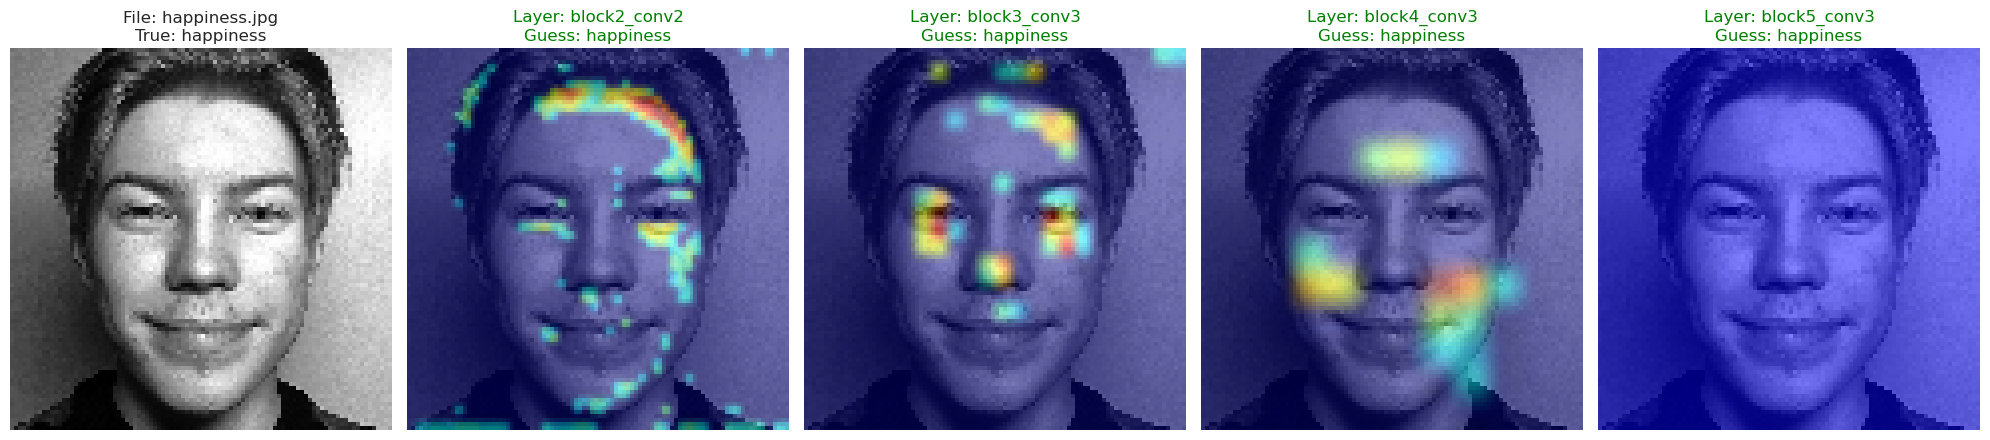

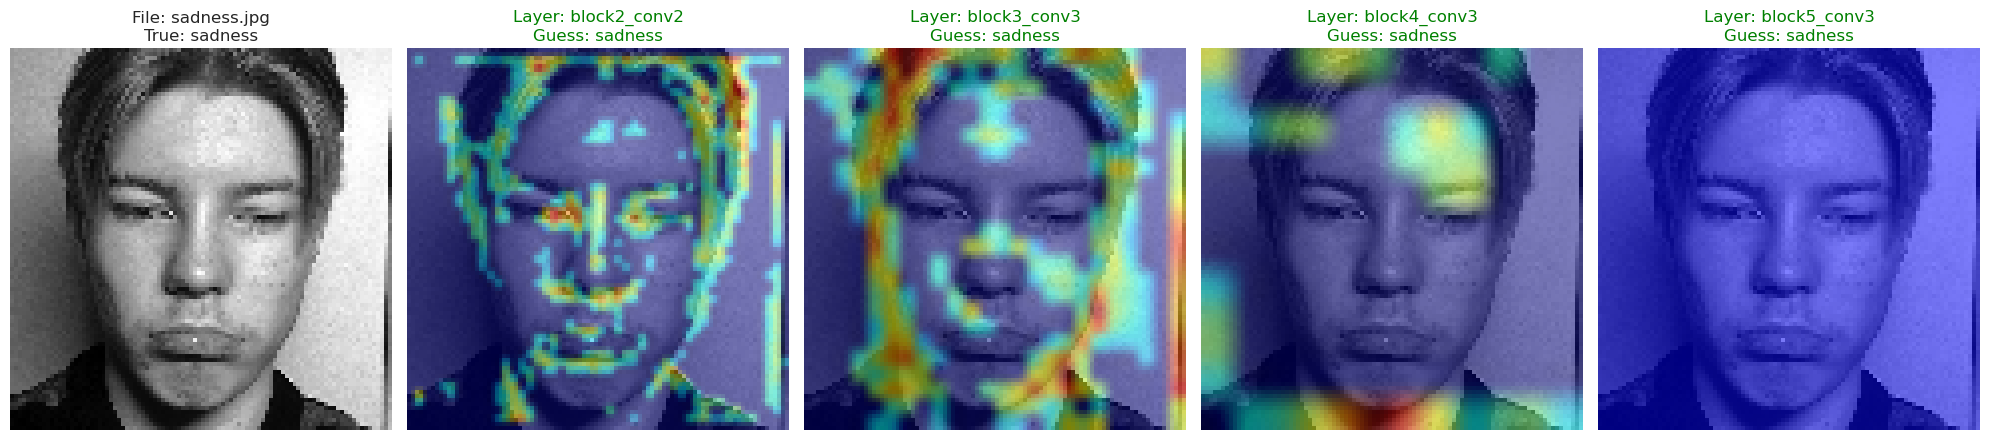

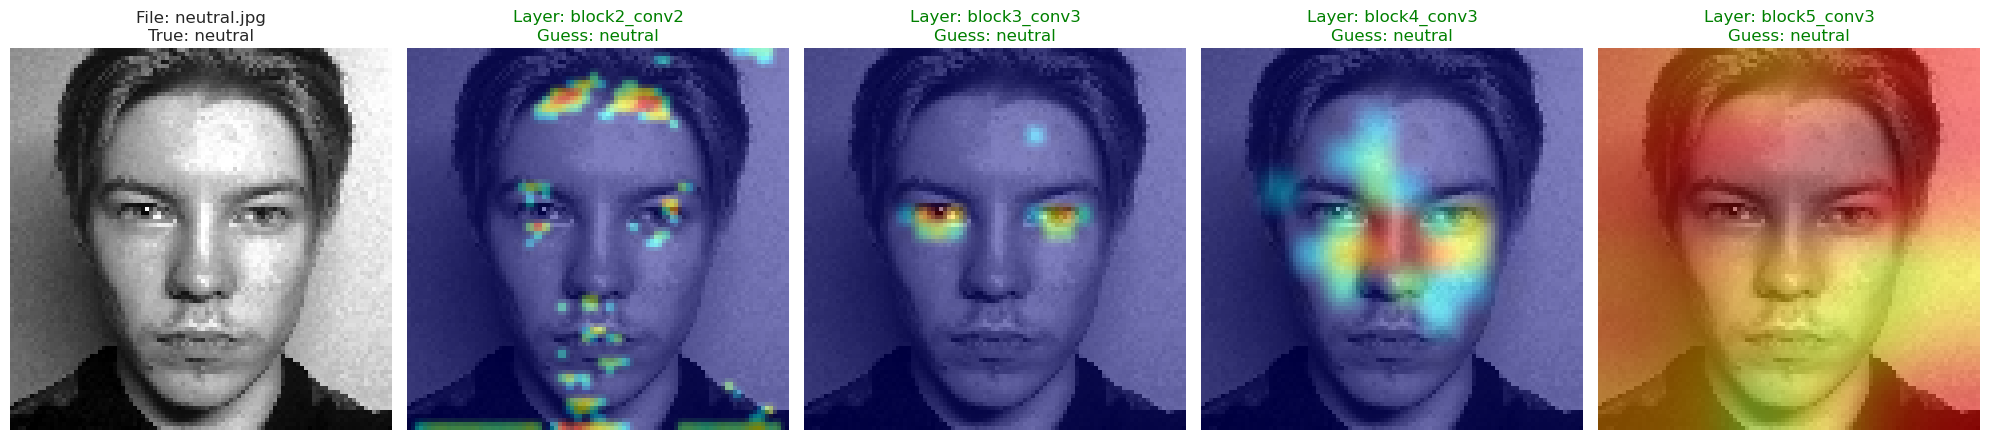

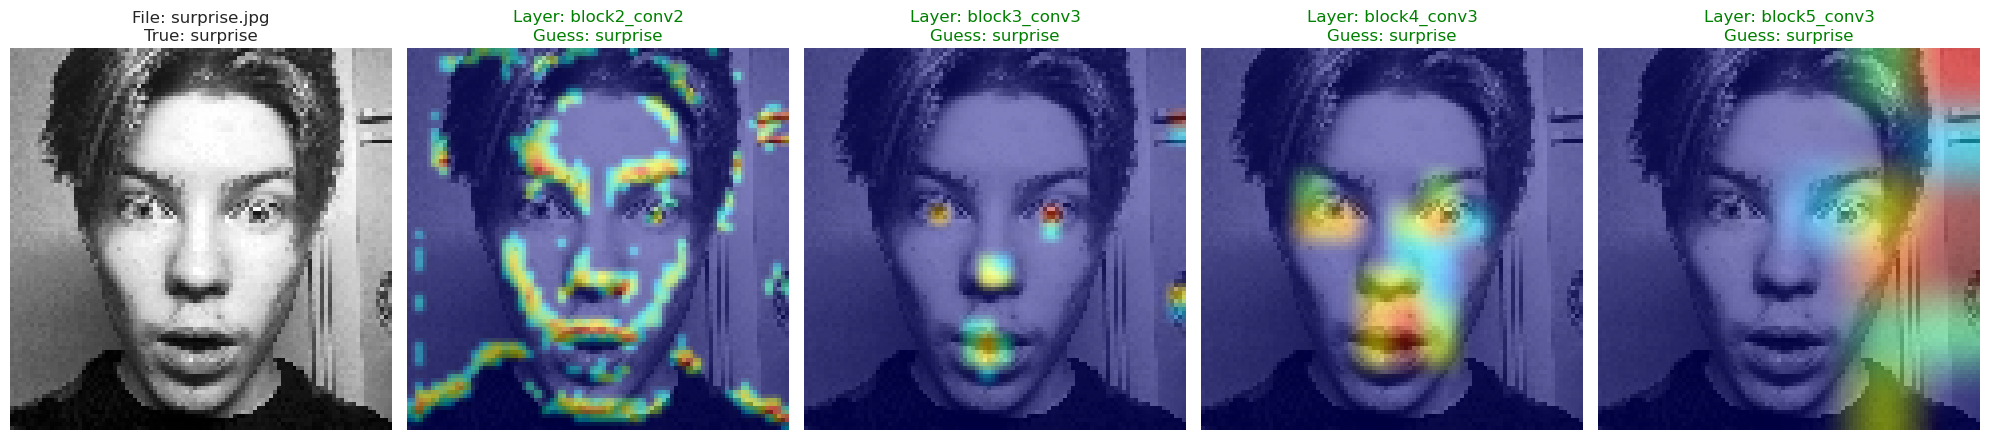

In [22]:
process_folder_heatmaps("./EetuCustomImages")